In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer #Data transformation
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
import re 
import nltk
from nltk import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\loukr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Importing Data

In [ ]:
df=pd.read_csv("twitter.csv")

In [ ]:
df.columns=['id','information','sentiment','text']
df

,id,information,sentiment,text
0,2401,Borderlands,Negative,I am coming to the borders and I will kill you...
1,2401,Borderlands,Negative,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Negative,im coming on borderlands and i will murder you...
3,2401,Borderlands,Negative,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Negative,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


#Data transformation

##Basic preprocessing (remove nulls,duplicates and irrelavant columns)

In [ ]:
labeled_df=df[["text","sentiment"]].copy()
labeled_df

,text,sentiment
0,I am coming to the borders and I will kill you...,Negative
1,im getting on borderlands and i will kill you ...,Negative
2,im coming on borderlands and i will murder you...,Negative
3,im getting on borderlands 2 and i will murder ...,Negative
4,im getting into borderlands and i can murder y...,Negative
...,...,...
74676,Just realized that the Windows partition of my...,Positive
74677,Just realized that my Mac window partition is ...,Positive
74678,Just realized the windows partition of my Mac ...,Positive
74679,Just realized between the windows partition of...,Positive


In [ ]:
labeled_df.dropna(inplace=True)
labeled_df.shape

(73995, 2)

In [ ]:
labeled_df.sentiment.value_counts()

Negative      22363
Positive      20649
Neutral       18108
Irrelevant    12875
Name: sentiment, dtype: int64

In [ ]:
labeled_df.drop_duplicates(inplace=True)
labeled_df.shape

(69766, 2)

##Create target from sentiments

In [ ]:
labeled_df["sentiment_target"]=labeled_df["sentiment"].factorize()[0]

##Visualization

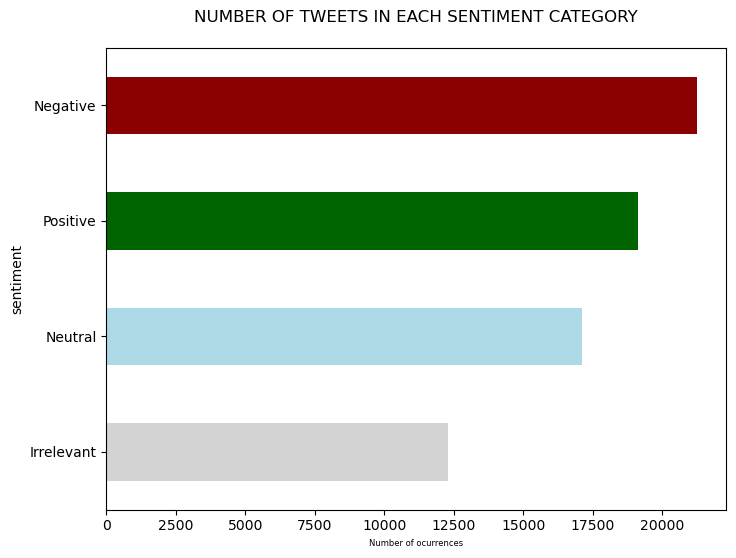

In [ ]:
fig = plt.figure(figsize=(8,6))
colors = ['lightgrey','lightblue','darkgreen', 'darkred']
labeled_df.groupby(['sentiment']).text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH SENTIMENT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 6);

##Remove links and users

In [ ]:
def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    tweet = re.sub('(@ [A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted with space
    return tweet
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
def preprocess(sent):
    sent = remove_users(sent)
    sent = remove_links(sent)
    sent = sent.lower() # lower case
    sent = re.sub('['+my_punctuation + ']+', ' ', sent) # strip punctuation
    sent = re.sub('\s+', ' ', sent) #remove double spacing
    sent = re.sub('([0-9]+)', '', sent) # remove numbers
    sent_token_list = [word for word in sent.split(' ')]
    sent = ' '.join(sent_token_list)
    return sent

In [ ]:
labeled_df['text']=labeled_df['text'].apply(lambda row : preprocess(row))

In [ ]:
labeled_df

,text,sentiment,sentiment_target
0,i am coming to the borders and i will kill you...,Negative,0
1,m getting on borderlands and i will kill you all,Negative,0
2,m coming on borderlands and i will murder you ...,Negative,0
3,m getting on borderlands and i will murder yo...,Negative,0
4,m getting into borderlands and i can murder yo...,Negative,0
...,...,...,...
74676,just realized that the windows partition of my...,Positive,1
74677,just realized that my mac window partition is ...,Positive,1
74678,just realized the windows partition of my mac ...,Positive,1
74679,just realized between the windows partition of...,Positive,1


##Remove Stopwords

In [ ]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\loukr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
labeled_df.head()

,text,sentiment,sentiment_target
0,i am coming to the borders and i will kill you...,Negative,0
1,m getting on borderlands and i will kill you all,Negative,0
2,m coming on borderlands and i will murder you ...,Negative,0
3,m getting on borderlands and i will murder yo...,Negative,0
4,m getting into borderlands and i can murder yo...,Negative,0


##Apply stemming

In [ ]:
def nltk_text_filter(text):
    word_tokens = word_tokenize(text) 
    #print(word_tokens)
    filtered_sentence = [] 
  
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

In [ ]:
labeled_df['text']=labeled_df['text'].apply(lambda row : nltk_text_filter(row))

In [ ]:
labeled_df.head()

,text,sentiment,sentiment_target
0,coming borders kill,Negative,0
1,getting borderlands kill,Negative,0
2,coming borderlands murder,Negative,0
3,getting borderlands murder,Negative,0
4,getting borderlands murder,Negative,0


#TFIDF IMPLEMENTATION

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

tfidf = TfidfVectorizer( 
    ngram_range=(1, 1) #analysis of one word
)

In [ ]:
sampled_data=labeled_df.sample(frac=0.4)
sampled_data.shape

(27906, 3)

##Split train test

In [ ]:
X=sampled_data["text"]
y=sampled_data['sentiment_target']

In [ ]:
X

71947    faced problem able go beyond ar due mid week c...
53022    new year eve blizzard red dead redemption onli...
33932    beat saber crazy fun damn going sweating loude...
8442                 may last team make difficult decision
12528    wana knows another wish list stop letting pf c...
                               ...                        
37852    almost certainly holy old god massive minion z...
52490              achievements red dead redemption points
13810                                    please give happy
61656    dream fill lobby gta iv online last night reac...
70458    remind playing game havin hard time pic twitte...
Name: text, Length: 27906, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

##TFIDF TRANSFORM

In [ ]:
#Creation of encoding related to train dataset
X_train_tfidf = tfidf.fit_transform(X_train)
#Transformation of test dataset with train encoding
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500)
X_train_k = svd.fit_transform(X_train_tfidf)
X_test_k = svd.transform(X_test_tfidf)

In [ ]:
print(X_train_tfidf.shape)
print(X_train_k.shape)

(19534, 19154)
(19534, 500)


#HYPERPARAMETER TUNING (GRID SEARCH) FOR EVERY KERNEL

In [ ]:
from datetime import datetime as dt
from sklearn.svm import SVC

##RBF TUNING

In [ ]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [
     {'C': [ 0.5, 1,5,7,10,100], 
              'gamma': [1, 0.75, 0.5, 0.1, 0.01],
              'kernel': ['rbf']} 
]

grid_search = GridSearchCV(estimator = SVC(), param_grid = tuned_parameters, 
                      cv = 3, n_jobs = -1)

In [ ]:
start = dt.now()
grid_search.fit(X_train_tfidf, y_train)
running_secs = (dt.now() - start).seconds
running_secs

804

In [ ]:
grid_search.best_params_ 

{'C': 5, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
y_pred=grid_search.predict(X_test_tfidf)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.827639751552795

##LINEAR TUNING

In [ ]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [
     {'C': [ 0.5, 1,5,7,10,100], 
              'kernel': ['linear']} 
]

grid_search = GridSearchCV(estimator = SVC(), param_grid = tuned_parameters, 
                      cv = 3, n_jobs = -1)

In [ ]:
start = dt.now()
grid_search.fit(X_train_tfidf, y_train)
running_secs = (dt.now() - start).seconds
running_secs

169

In [ ]:
grid_search.best_params_ 

{'C': 5, 'kernel': 'linear'}

In [ ]:
y_pred=grid_search.predict(X_test_tfidf)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7558528428093646

##POLY

In [ ]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [
     {'C': [ 0.5, 1,5,7,10], 
              'gamma': [1, 0.75, 0.5, 0.1, 0.01],
              'kernel': ['poly']} 
]

grid_search = GridSearchCV(estimator = SVC(), param_grid = tuned_parameters, 
                      cv = 3, n_jobs = -1)

In [ ]:
start = dt.now()
grid_search.fit(X_train_tfidf, y_train)
running_secs = (dt.now() - start).seconds
running_secs

743

In [ ]:
grid_search.best_params_ 

{'C': 10, 'gamma': 0.5, 'kernel': 'poly'}

In [ ]:
y_pred=grid_search.predict(X_test_tfidf)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8236980410893454